In [14]:
# Importamos las librerias que usaremos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import matplotlib.gridspec as gridspec
import matplotlib.pylab as pl

In [15]:
# Importamos la base de datos
data = pd.read_csv("AccidentesAviones.csv")
data.sample(3)

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
729,729,"July 26, 1944",0300,North Atlantic Ocean,Military - U.S. Army Air Forces,?,"England - Long Island, N.Y.",Douglas C-54A-DO (DC-4),42-107470,7489,26,20,6,26,20,6,0,Disappeared while en route from Iceland to New...
4701,4701,"October 15, 2008",2358,"Aurora, Illinois",Air Angles Inc.,?,Sandwich - Chicago,Bell 222,N992AA,47062,4,1,3,4,1,3,0,"The helicopter clipped a radio tower wire, cra..."
3836,3836,"May 15, 1993",?,"Near Cancun, Mexico",Carga del Caribe,?,Cancun - Cozumel,Douglas DC-6BF,XA-SEA,43825/315,5,0,5,3,0,3,0,The cargo plane crashed under unknown circumst...


In [16]:
data.shape

(5008, 18)

In [17]:
data = data.replace('?', np.nan)
data.isnull().sum() #Calculamos valores nulos en las columnas

Unnamed: 0                   0
fecha                        0
HORA declarada            1504
Ruta                         5
OperadOR                    10
flight_no                 3682
route                      762
ac_type                     13
registration               272
cn_ln                      667
all_aboard                  17
PASAJEROS A BORDO          221
crew_aboard                219
cantidad de fallecidos       8
passenger_fatalities       235
crew_fatalities            235
ground                      44
summary                     59
dtype: int64

In [18]:
#Eliminamos las columnas que no vamos a utilizar
data = data.drop(['Unnamed: 0','flight_no', 'cn_ln', 'PASAJEROS A BORDO', 'crew_aboard', 'passenger_fatalities', 'crew_fatalities'], axis=1)
data.columns

Index(['fecha', 'HORA declarada', 'Ruta', 'OperadOR', 'route', 'ac_type',
       'registration', 'all_aboard', 'cantidad de fallecidos', 'ground',
       'summary'],
      dtype='object')

In [19]:
#Normalizamos el nombre de las columnas
nombres_corregidos = {
    'fecha': 'Date',
    'HORA declarada': 'Time',
    'Ruta': 'Location',
    'OperadOR': 'Operator',
    'route': 'Route',
    'ac_type': 'Type',
    'registration': 'Registration',
    'all_aboard': 'Aboard',
    'cantidad de fallecidos': 'Fatalities',
    'ground': 'Ground',
    'summary': 'Summary'
}
data = data.rename(columns=nombres_corregidos)
data.columns

Index(['Date', 'Time', 'Location', 'Operator', 'Route', 'Type', 'Registration',
       'Aboard', 'Fatalities', 'Ground', 'Summary'],
      dtype='object')

In [20]:
#Convertimos la columna "Date" a formato fecha Y/m/d
data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%Y/%m/%d')
data['Time'].fillna('?', inplace=True)
data['Time'] = data['Time'].str.replace('00:7', '00:07') #Reemplazo especifico
data['Time'] = data['Time'].str.replace('175', '17:05') #Reemplazo Especifico
data['Time'] = data['Time'].str.replace('c', '') #Quitamos las c
data["Time"] = data["Time"].str.replace("Z", "") #Quitamos las Z
def formatear_tiempo(valor): #Creamos una función para agregarle los 0 por delante
    if ':' in valor:         # a los valores #:##
        partes = valor.split(':')
        partes[1] = partes[1].strip().zfill(2)
        valor = ':'.join(partes)
    return valor
data['Time'] = data['Time'].apply(formatear_tiempo)
data["Time"] = data["Time"].str.replace(":", "") #Reemplazamos los ':' por cadena vacia
data["Time"] = data["Time"].str.replace(";", "") #Reemplazamos los ';' por cadena vacia
data['Time'] = data['Time'].str.strip() #Quitamos los espacios en blanco
data['Time'] = data['Time'].apply(lambda x: x.zfill(4) if x.isdigit() else x) #Le agregamos un 0 a los numeros con 3 digitos
data['Time'] = data['Time'].replace('?', '0000') #Reemplazamos los ? por 0000

data['Time'] = pd.to_datetime(data['Time'], format='%H%M', errors='coerce').dt.strftime('%H:%M')
data['DateTime'] = data['Date'] + ' ' + data['Time'] #Creamos una nueva columna sumando 'Date' y 'Time'
data['DateTime'] = pd.to_datetime(data['DateTime']) #Lo convertimos a formato DateTime

In [21]:
data = data.drop(['Time'], axis=1)
print('Rango de datos ' + str(data.DateTime.min()) + ' to ' + str(data.DateTime.max()))

Rango de datos 1908-09-17 17:18:00 to 2021-07-06 15:00:00


In [22]:
data.Operator = data.Operator.str.upper() #Solo para evitar duplicados como 'British Airlines' y 'BRITISH Airlines'
#Eliminamos los saltos de linea /r o \r    
columns_to_replace = ['Location', 'Operator', 'Route', 'Type', 'Registration', 'Summary']
data[columns_to_replace] = data[columns_to_replace].replace(to_replace=r'/r|\\r', value='/', regex=True)

data['Route'] = data['Route'].fillna('Not defined')
data['Summary'] = data['Summary'].fillna('No comments')
data['Operator'] = data['Operator'].fillna('Unknown')
data['Type'] = data['Type'].fillna('No Type')

In [23]:
#Convertimos las columnas de object a Float
columns_to_convert = ['Aboard', 'Fatalities', 'Ground']

for column in columns_to_convert:
    data[column] = pd.to_numeric(data[column], errors='coerce')

In [24]:
#Creamos una columna con el nombre de los paises
s = data['Location'].str[0:].str.split(',', expand=True)
data['Country'] = s[3].fillna(s[2]).fillna(s[1]).str.strip()

#Colocamos dentro de la variable usNames todos los estados de USA
usNames = ['Virginia','New Jersey','Ohio','Pennsylvania', 'Maryland', 'Indiana', 'Iowa', 'Mississipi',
          'Illinois','Wyoming', 'Minnisota', 'Wisconsin', 'Nevada', 'NY','California', 'South Dakota',
          'WY','New York','Oregon', 'Idaho', 'Connecticut','Nebraska', 'Minnesota', 'Kansas',
          'Texas', 'Tennessee', 'West Virginia', 'New Mexico', 'Washington', 'Massachusetts', 'South Carolina',
          'Utah', 'Ilinois','Florida', 'Michigan', 'Missouri','Arkansas','Colorado', 'Georgia','Missouri',
          'Montana', 'Mississippi','Jersey', 'Cailifornia', 'Oklahoma','North Carolina', 'Californiia',
          'Kentucky','Delaware','D.C.','Arazona','Arizona','South Dekota','New Hampshire','Hawaii',
          'Washingon','Massachusett','Washington DC','Tennesee','Deleware','Louisiana', 'US Virgin Islands', 'U.S. Virgin Islands',
          'Massachutes', 'Louisana', 'New York (Idlewild)','Oklohoma','North Dakota','Rhode Island',
          'Maine','Wisconson','Calilfornia','Virginia','Virginia.','CA','Vermont', 'Mississipi', 'Massachusetts',
          'HI','AK','IN','GA','Coloado','Airzona','Alabama', 'United States', 'Alaksa', 'Alaska', 'Alakska'
          ]
canNames = ['Ontario', 'British Columbia Canada','Saskatchewan','Canada2', 'Newfoundland', 'Quebec Canada', 'Northwest Territories Canada']
rusNames = ['Russian'] #Russia
sovNames = ['USSR'] #Soviet Union


clnames = []
for country in data['Country'].values:
    if country in rusNames:
         clnames.append('Russia')
    elif country in usNames:
        clnames.append('USA')
    elif country in canNames:
        clnames.append('Canada')
    elif country in sovNames:
        clnames.append('Soviet Union')
    else:
        clnames.append(country)

data['Cleaned Country'] = clnames

In [25]:
data['Cleaned Country'] = data['Cleaned Country'].replace('Bulgeria', 'Bulgaria')
data['Cleaned Country'] = data['Cleaned Country'].replace('Bugaria', 'Bulgaria')
data['Cleaned Country'] = data['Cleaned Country'].replace('Boliva', 'Bolivia')
data['Cleaned Country'] = data['Cleaned Country'].replace('West Germany', 'Germany')
data['Cleaned Country'] = data['Cleaned Country'].replace('East Germany', 'Germany')
data['Cleaned Country'] = data['Cleaned Country'].replace('Guizhou Province', 'China')
data['Cleaned Country'] = data['Cleaned Country'].replace('East Sardinia', 'Italy')
data['Cleaned Country'] = data['Cleaned Country'].replace('Okinawa', 'Japan')
data['Cleaned Country'] = data['Cleaned Country'].replace('Spain\rCanary Islands', 'Spain')
data['Cleaned Country'] = data['Cleaned Country'].replace('Canary islands', 'Spain')
data['Cleaned Country'] = data['Cleaned Country'].replace('Aregntina', 'Argentina')
data['Cleaned Country'] = data['Cleaned Country'].replace('Unied Kingdom', 'United Kingdom')
data['Cleaned Country'] = data['Cleaned Country'].replace('UK', 'United Kingdom')
data['Cleaned Country'] = data['Cleaned Country'].replace('Morroco', 'Morocco')
data['Cleaned Country'] = data['Cleaned Country'].replace('Columbia', 'Colombia')
data['Cleaned Country'] = data['Cleaned Country'].replace('Coatia', 'Croatia')
data['Cleaned Country'] = data['Cleaned Country'].replace('Inodnesia', 'Indonesia')
data['Cleaned Country'] = data['Cleaned Country'].replace('Phillipines', 'Philippines')
data['Cleaned Country'] = data['Cleaned Country'].replace('Philipines', 'Philippines')
data['Cleaned Country'] = data['Cleaned Country'].replace('Australila', 'Australia')
data['Cleaned Country'] = data['Cleaned Country'].replace('Indian', 'India')
data['Cleaned Country'] = data['Cleaned Country'].replace('India.', 'India')
data['Cleaned Country'] = data['Cleaned Country'].replace('Afghanstan', 'Afghanistan')
data['Cleaned Country'] = data['Cleaned Country'].replace('Napal', 'Nepal')
data['Cleaned Country'] = data['Cleaned Country'].fillna('Not defined')
data.sample(3)

,Date,Location,Operator,Route,Type,Registration,Aboard,Fatalities,Ground,Summary,DateTime,Country,Cleaned Country
1488,1954/11/16,"Jirishanga,Cerro de Pasco, Peru",TAM (BRAZIL),Pucallpa - Lima,Douglas DC-3,FAP-403,24.0,24.0,0.0,Disappeared over the Andes while en route. Wre...,1954-11-16 00:00:00,Peru,Peru
3642,1990/04/26,"Near Manila, Philippines",MATS - MANILA AERO TRANSPORT SYSTEM,Manila - Roxaz City,Douglas DC-3 (C-47A-30-DK),RP-C81,24.0,7.0,0.0,The plane crashed into a rice field after an e...,1990-04-26 06:21:00,Philippines,Philippines
1133,1949/08/27,"Leopoldville, Zaire",SABENA,Leopoldville - Elizabethville,Douglas C-47B-5-DK,OO-CBK,20.0,5.0,0.0,The aircraft did not achieve a proper climb ra...,1949-08-27 08:00:00,Zaire,Zaire


In [26]:
# Renombramos la Columna Country
data = data.drop(['Location', 'Country'], axis=1)
data = data.rename(columns={'Cleaned Country': 'Country'})
#Creamos 3 nuevas columnas
data['Survived'] = data['Aboard'] - data['Fatalities']
data["Survival Rate"] = 100 * (data["Survived"]) / data["Aboard"]
data["Is Military"] = data['Operator'].str.contains("MILITARY",regex=False)
data.sample(3)

,Date,Operator,Route,Type,Registration,Aboard,Fatalities,Ground,Summary,DateTime,Country,Survived,Survival Rate,Is Military
2375,1968/12/12,PAN AMERICAN WORLD AIRWAYS,New York City - Caracas,Boeing B-707-321B,N494PA,51.0,51.0,0.0,"En route from New York City, the airliner cras...",1968-12-12 22:02:00,Venezuela,0.0,0.0,False
3362,1985/12/12,ARROW AIRWAYS,"Gander - Fort Campbell, KY",McDonnell Douglas DC-8 Super 63PF,N950JW,256.0,256.0,0.0,The aircraft stalled and crashed during takeof...,1985-12-12 06:45:00,Canada,0.0,0.0,False
4200,1999/04/07,MANACÁ TÁXI AÉREO,Training,Learjet 24D,PT-LEM,5.0,5.0,0.0,The pilot-in-command lost control during touch...,1999-04-07 11:30:00,Brazil,0.0,0.0,False


Asignamos el Tipo de variable a cada Columna<br>
Country = Cualitativa<br>
Operator = Cualitativa<br>
Route = Cualitativa<br>
Type = Cualitativa<br>
Registration = Cualitativa<br>
Aboard = Cuantitativa Discreta<br>
Fatalities = Cuantitativa discreta<br>
Ground = Cuantitativa discreta<br>
DateTime = Puede tomarse como Cualitativo o Cuantitativo<br>
Survived = Cuantitativa/Discreta<br>
Survival Rate = Cualitativa/Ordinal<br> 
Is Military = Cualitativa/Dicotomica

In [27]:
#Creamos columnas Relacionados a la fecha
data['Year'] = pd.DatetimeIndex(data['Date']).year
data['Month'] = pd.DatetimeIndex(data['Date']).month
data['Day'] = pd.DatetimeIndex(data['Date']).day
data['Decade'] = (data['Year']) // 10 * 10
data['Date of Year'] = data['Month'].astype(str) +'/'+ data['Day'].astype(str)
data['Day of Week'] = pd.DatetimeIndex(data['Date']).day_name()
#Colocamos los nombres a los meses
meses = {
    1: "Enero",
    2: "Febrero",
    3: "Marzo",
    4: "Abril",
    5: "Mayo",
    6: "Junio",
    7: "Julio",
    8: "Agosto",
    9: "Septiembre",
    10: "Octubre",
    11: "Noviembre",
    12: "Diciembre"
}
data['Month'] = data['Month'].map(meses)
data.sample(3)

,Date,Operator,Route,Type,Registration,Aboard,Fatalities,Ground,Summary,DateTime,Country,Survived,Survival Rate,Is Military,Year,Month,Day,Decade,Date of Year,Day of Week
3130,1981/06/14,AEROFLOT,Ulan - Severomuysk,Ilyushin Il-14,CCCP-41838,48.0,48.0,0.0,The crew informed ATC they could see the field...,1981-06-14 16:22:00,Russia,0.0,0.000000,False,1981,Junio,14,1980,6/14,Sunday
23,1918/12/16,US AERIAL MAIL SERVICE,Not defined,De Havilland DH-4,97,1.0,1.0,0.0,Carl Smith was killed when his mail plane feet...,1918-12-16 00:00:00,USA,0.0,0.000000,False,1918,Diciembre,16,1910,12/16,Monday
4920,2015/11/04,ALLIED SERVICES LIMITED,Juba - Paloich,Antonov 12BK,EY-406,43.0,41.0,0.0,The cargo plane had just taken off from Juba A...,2015-11-04 09:00:00,South Sudan,2.0,4.651163,False,2015,Noviembre,4,2010,11/4,Wednesday


## DATA VISUALIZATION

### Accidentes por década

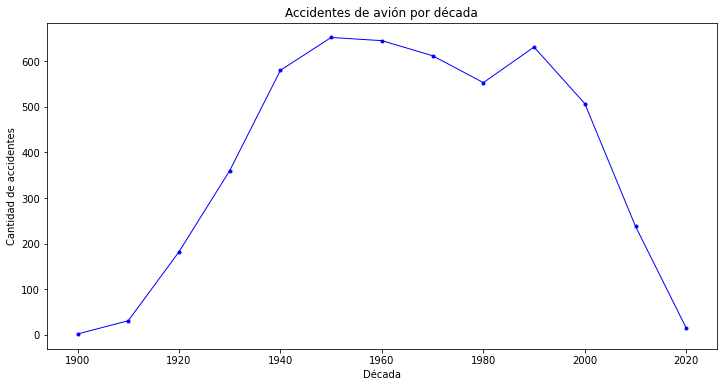

In [28]:
accidentes_por_decada = data.groupby('Decade').size()
fig, ax = plt.subplots(figsize=[12, 6])
accidentes_por_decada.plot(kind='line', ax=ax, color='blue', marker='.', linewidth=1)
ax.set_xlabel('Década')
ax.set_ylabel('Cantidad de accidentes')
ax.set_title('Accidentes de avión por década')
plt.show()

### Cantidad de accidentes por año

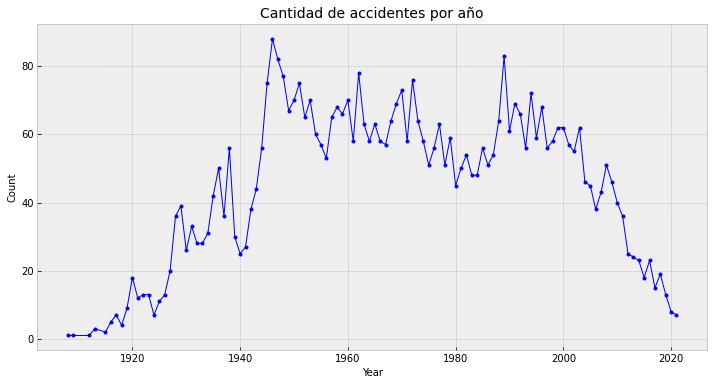

In [29]:
Temp = data.groupby(data.DateTime.dt.year)[['Date']].count()
Temp = Temp.rename(columns={"Date": "Count"})
plt.figure(figsize=(12,6))
plt.style.use('bmh')
plt.plot(Temp.index, 'Count', data=Temp, color='blue', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Cantidad de accidentes por año', loc='Center', fontsize=14)
plt.show()

### Cantidad de accidentes por mes

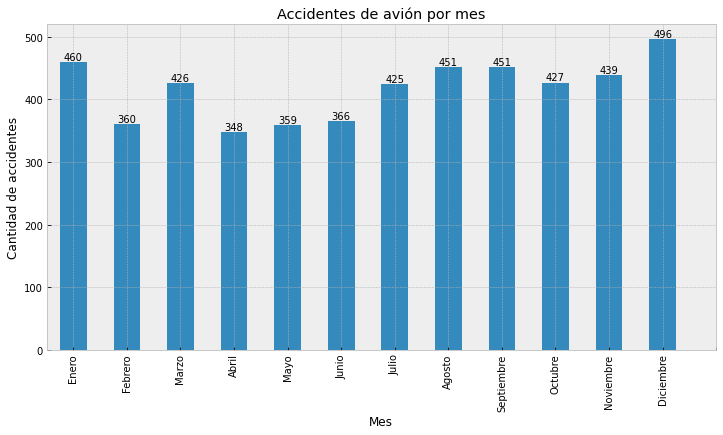

In [30]:
meses = ["Enero","Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]
data['Month'] = pd.Categorical(data['Month'], categories=meses, ordered=True)
# Agrupar los accidentes por mes y contar la cantidad de accidentes en cada mes
accidentes_por_mes = data.groupby('Month').size()

# Crear el gráfico de líneas
fig, ax = plt.subplots(figsize=[12, 6])
accidentes_por_mes.plot(kind='bar', ax=ax)

# Configurar los ejes y las etiquetas
ax.set_xlabel('Mes')
ax.set_ylabel('Cantidad de accidentes')
ax.set_title('Accidentes de avión por mes')
# ax.set_xticklabels(meses, rotation=45)
ax.set_xticks(range(0, 13))  # Establecer las marcas de los meses
# Agregar etiquetas de número sobre cada barra
for i, v in enumerate(accidentes_por_mes):
    ax.text(i, v, str(v), ha='center', va='bottom')
# Mostrar el gráfico
plt.show()

### Cantidad de accidentes por día historicamente

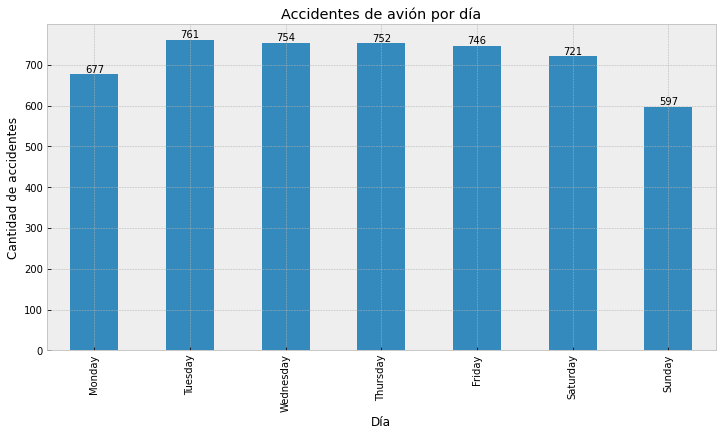

In [31]:
dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['Day of Week'] = pd.Categorical(data['Day of Week'], categories=dias_semana, ordered=True)
# Agrupar los datos por día de la semana y contar la cantidad de accidentes
accidentes_por_dia = data.groupby('Day of Week').size()

# Crear el gráfico de líneas
fig, ax = plt.subplots(figsize=[12, 6])
accidentes_por_dia.plot(kind='bar', ax=ax)

# Configurar los ejes y las etiquetas
ax.set_xlabel('Día')
ax.set_ylabel('Cantidad de accidentes')
ax.set_title('Accidentes de avión por día')
ax.set_xticks(range(0, 7))  # Establecer las marcas de los meses

# Agregar etiquetas de número sobre cada barra
for i, v in enumerate(accidentes_por_dia):
    ax.text(i, v, str(v), ha='center', va='bottom')
    
# Mostrar el gráfico
plt.show()

### Cantidad de Muertes por Año

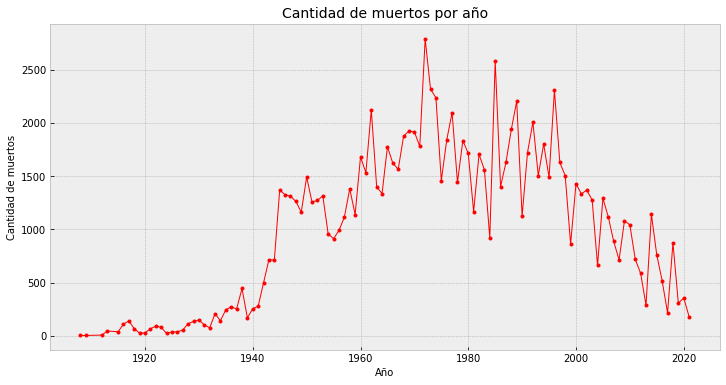

In [32]:
# Muertos (Fatalities) por año
# Agrupar por año y sumar los valores de la columna 'Fatalities'
muertos_por_anio = data.groupby('Year')['Fatalities'].sum()

plt.figure(figsize=(12,6))
plt.style.use('bmh')
plt.plot(muertos_por_anio.index, muertos_por_anio.values, color='red', marker='.', linewidth=1)
plt.xlabel('Año', fontsize=10)
plt.ylabel('Cantidad de muertos', fontsize=10)
plt.title('Cantidad de muertos por año', loc='center', fontsize=14)
plt.show()

### Tipo de Avion

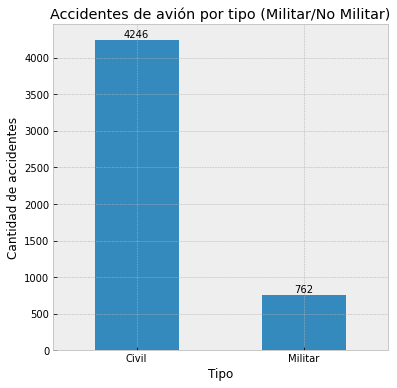

In [33]:
# Contar la cantidad de accidentes por tipo (militar o civil)
accidentes_por_tipo = data['Is Military'].value_counts()

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=[6, 6])
accidentes_por_tipo.plot(kind='bar', ax=ax)

# Configurar los ejes y las etiquetas
ax.set_xlabel('Tipo')
ax.set_ylabel('Cantidad de accidentes')
ax.set_title('Accidentes de avión por tipo (Militar/No Militar)')
ax.set_xticklabels(['Civil', 'Militar'], rotation=0)

# Agregar etiquetas de número sobre cada barra
for i, v in enumerate(accidentes_por_tipo):
    ax.text(i, v, str(v), ha='center', va='bottom')
# Mostrar el gráfico
plt.show()

### Accidentes por año y el tipo de avión

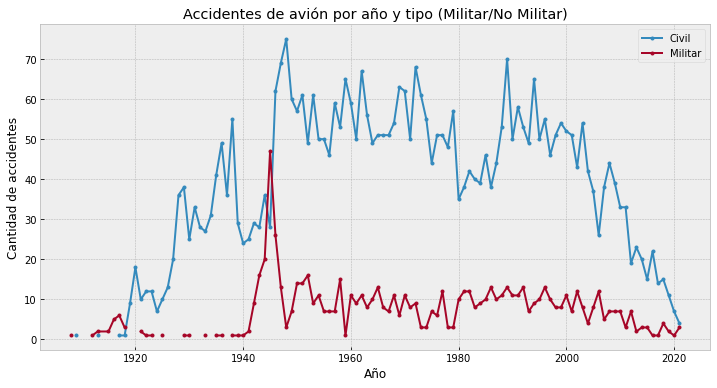

In [34]:
# Agrupar los accidentes por año y tipo (militar o civil)
accidentes_por_año_tipo = data.groupby(['Year', 'Is Military']).size().unstack()

# Crear el gráfico de líneas
fig, ax = plt.subplots(figsize=[12, 6])
accidentes_por_año_tipo.plot(kind='line', marker='.', ax=ax)

# Configurar los ejes y las etiquetas
ax.set_xlabel('Año')
ax.set_ylabel('Cantidad de accidentes')
ax.set_title('Accidentes de avión por año y tipo (Militar/No Militar)')
ax.legend(['Civil', 'Militar'])

# Mostrar el gráfico
plt.show()

### Personas abordo involucrados por año

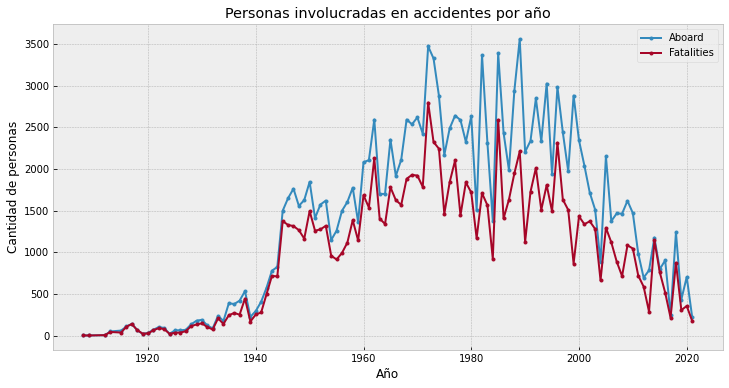

In [35]:
# Agrupar los accidentes por año y calcular la suma de personas a bordo y fallecidas
personas_por_año = data.groupby('Year')[['Aboard', 'Fatalities']].sum()

# Crear el gráfico de líneas
fig, ax = plt.subplots(figsize=[12, 6])
personas_por_año['Aboard'].plot(kind='line', marker='.', ax=ax, label='Aboard')
personas_por_año['Fatalities'].plot(kind='line', marker='.', ax=ax, label='Fatalities')

# Configurar los ejes y las etiquetas
ax.set_xlabel('Año')
ax.set_ylabel('Cantidad de personas')
ax.set_title('Personas involucradas en accidentes por año')
ax.legend()

# Mostrar el gráfico
plt.show()

Desde el comienzo de la aviación masiva a principios del siglo XX, el número de accidentes aéreos fue en aumento (probablemente debido al desarrollo de la aviación). Alcanzó el punto máximo en 1970, pero desde 1970 podemos ver el declive de Crashes (probablemente debido a la mejora de las medidas de seguridad). La aviación se está desarrollando, pero no hay tantos accidentes.

### Fatality Ratio x Año

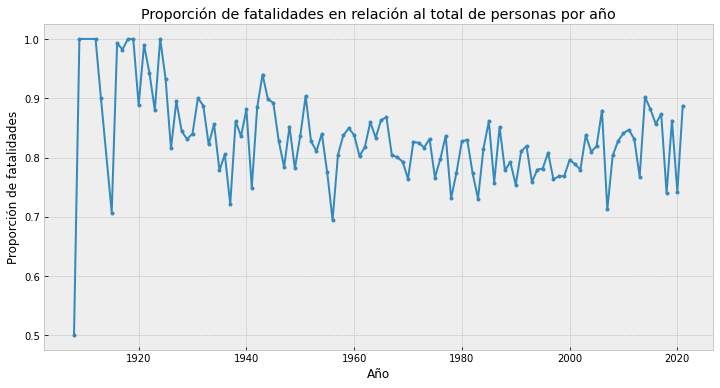

In [36]:
# Calcular la proporción de fatalidades en relación al total de personas por año
data['Fatality_Ratio'] = data['Fatalities'] / data['Aboard']
fatalidades_por_año = data.groupby('Year')['Fatality_Ratio'].mean()

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=[12, 6])
fatalidades_por_año.plot(kind='line', marker='.', ax=ax)

# Configurar los ejes y las etiquetas
ax.set_xlabel('Año')
ax.set_ylabel('Proporción de fatalidades')
ax.set_title('Proporción de fatalidades en relación al total de personas por año')

# Mostrar el gráfico
plt.show()

### Averiguamos el Tipo de avion con más pasajeros fallecidos

In [37]:
df_fatal = data.groupby('Type')[['Fatalities']].sum()
df_fatal_sorted = df_fatal.sort_values('Fatalities', ascending=False)
df_fatal_sorted.head(5)

,Fatalities
Type,
Douglas DC-3,4725.0
Douglas C-47,1059.0
Douglas DC-6B,1051.0
Antonov AN-26,1038.0
Ilyushin IL-18B,1008.0


### Gráfica con los muertos en accidentes para los distintos modelos de avión


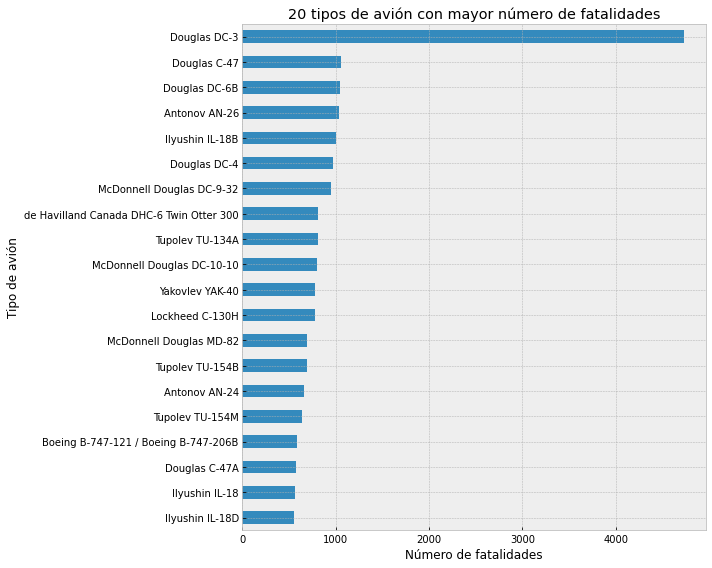

In [38]:
# Agrupar los datos por tipo de avión y sumar los valores de Fatalities
type_fatalities_sum = data[['Type', 'Fatalities']].groupby('Type').sum()
# Seleccionar los 20 primeros tipos de avión con mayor número de fatalidades y ordenar de forma descendente
top_20_types = type_fatalities_sum.nlargest(20, 'Fatalities')
# Crear la figura y los ejes del gráfico
fig, ax = plt.subplots(figsize=(10, 8))
# Trazar el gráfico de barras horizontales
top_20_types['Fatalities'].sort_values().plot(kind='barh', ax=ax)
# Establecer el título y etiquetas de los ejes
ax.set_title('20 tipos de avión con mayor número de fatalidades')
ax.set_xlabel('Número de fatalidades')
ax.set_ylabel('Tipo de avión')
# Mostrar el gráfico
plt.tight_layout()
plt.show()

Con el modelo Douglas DC-3 han muerto más de 4000 personas más de 4 veces más que el siguiente modelo de avión con más siniestros.

### Total de pasajeros por año

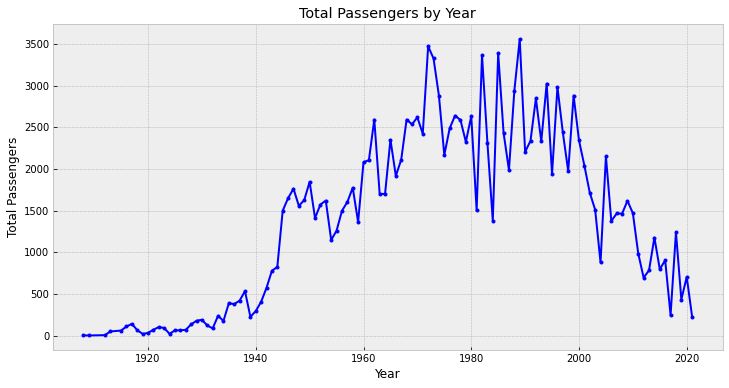

In [39]:
# Agrupar los datos por año y sumar el número de pasajeros a bordo
passengers_by_year = data.groupby('Year')['Aboard'].sum()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
passengers_by_year.plot(kind='line', marker='.', color='blue')

# Personalizar el gráfico
plt.xlabel('Year')
plt.ylabel('Total Passengers')
plt.title('Total Passengers by Year')

# Mostrar el gráfico
plt.show()

Problemas con datos engañosos
Por lo tanto, las tramas anteriores pueden parecer aterradoras: el número de muertes se volvió tan alto (aun así, parece que la tendencia disminuye después de los 90). Los gráficos no muestran la proporción de accidentes por todos los vuelos por año. Entonces, 1970-1990 parecen años aterradores en la historia de los vuelos aéreos con un aumento de muertes, pero también podría haber un aumento en la cantidad total de personas que vuelan por aire, mientras que en realidad la proporción disminuyó.

Estaba buscando en Google la base de datos del número total de vuelos o pasajeros y hasta ahora solo pude encontrar este conjunto de datos de worldbank.org. Así que cargué un conjunto de datos .csv de ese sitio y veamos qué tenemos.

In [40]:
Totals = pd.read_csv('API.csv')
Totals.sample(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
144,Luxembourg,LUX,Air transport - registered carrier departures ...,IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,44059.0,47215.0,48569.0,48255.0,48289.0,51824.0,51938.0,32964.6,36357.0,NaN
178,Nepal,NPL,Air transport - registered carrier departures ...,IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,30612.0,19560.0,19395.0,24063.0,58880.0,97598.0,27035.0,35894.0,28642.0,NaN


### Eliminamos las columnas innecesarias y nos quedamos con los años y sus valores

In [41]:
Fatalities = data.groupby(data.DateTime.dt.year).sum()
# Convertir el índice del DataFrame a tipo entero
Totals.index = Totals.index.astype(int)

# Realizar las operaciones en el DataFrame
Totals = Totals.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
Totals = Totals.replace(np.nan, 0)
Totals = pd.DataFrame(Totals.sum())
Totals = Totals.drop(Totals.index[0:10])
Totals = Totals['1970':'2021']
Totals.columns = ['Passengers']
Totals.index.name = 'Year'

### Reseteamos el Index con el numero del año

In [42]:
Fatalities = Fatalities.reset_index().astype(int)
Fatalities.DateTime = Fatalities.DateTime.apply(str)
Fatalities.index = Fatalities['DateTime']
del Fatalities['DateTime']
Fatalities = Fatalities['1970':'2021']
# Fatalities = Fatalities['1970':'2017']
Fatalities = Fatalities[['Fatalities']]
Totals = pd.concat([Totals, Fatalities], axis=1) #joining two data frames into one
Totals['Ratio'] = Totals['Fatalities'] / Totals['Passengers'] * 100 #calculating ratio

In [43]:
Totals['Año'] = Totals.index
Totals.head()

,Passengers,Fatalities,Ratio,Año
1970,57053400.0,1920,0.003365,1970
1971,57472700.0,1784,0.003104,1971
1972,48266700.0,2795,0.005791,1972
1973,59104500.0,2323,0.003930,1973
1974,64818300.0,2242,0.003459,1974


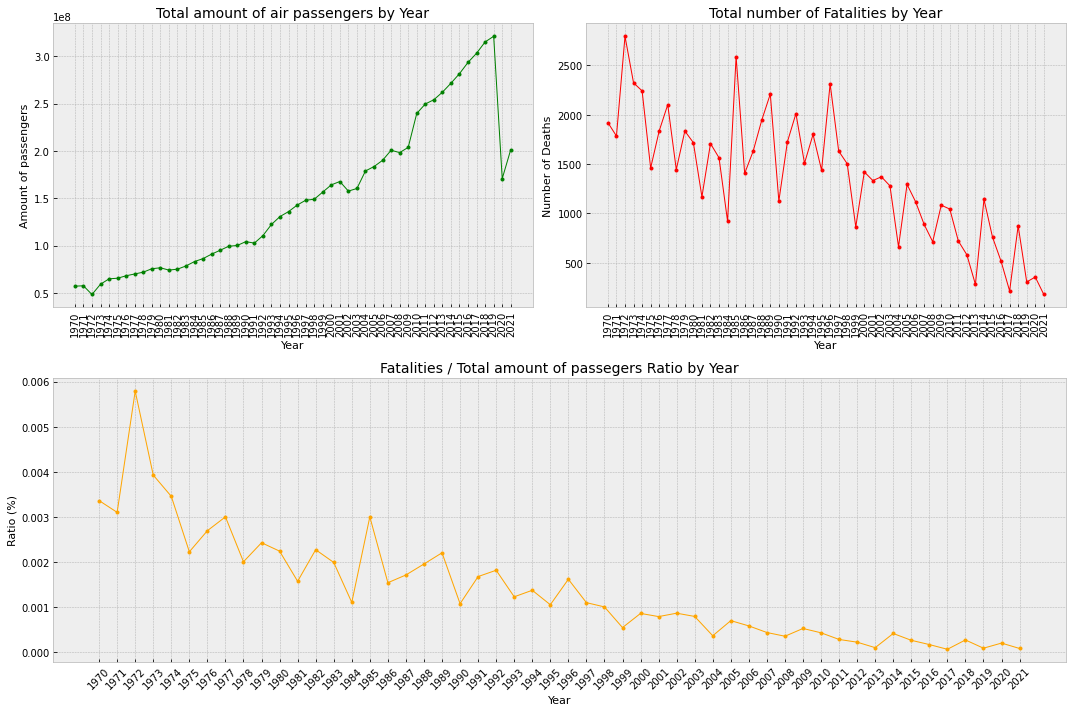

In [44]:
gs = gridspec.GridSpec(2, 2)
pl.figure(figsize=(15,10))

ax = pl.subplot(gs[0, 0]) 
plt.plot(Totals.index, 'Passengers', data=Totals, marker = ".", color = 'green', linewidth=1)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Amount of passengers', fontsize=11)
plt.title('Total amount of air passengers by Year', loc='Center', fontsize=14)
plt.xticks(rotation=90)

ax = pl.subplot(gs[0, 1]) 
plt.plot(Fatalities.index, 'Fatalities', data=Fatalities, color='red', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Number of Deaths', fontsize=11)
plt.title('Total number of Fatalities by Year', loc='Center', fontsize=14)
plt.xticks(rotation=90)

ax = pl.subplot(gs[1, :]) 
plt.plot(Totals.index, 'Ratio', data=Totals, color='orange', marker = ".", linewidth=1)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Ratio (%)', fontsize=11)
plt.title('Fatalities / Total amount of passegers Ratio by Year', loc='Center', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Vemos en la Primera Grafica el incremento de pasajeros al pasar de los años.
2. Vemos en la Segunda Grafica la reducción de muertos al pasar de los años.
3. Vemos en la Tercera Grafica como la tasa de muertes por pasajeros se va reduciendo año a año.

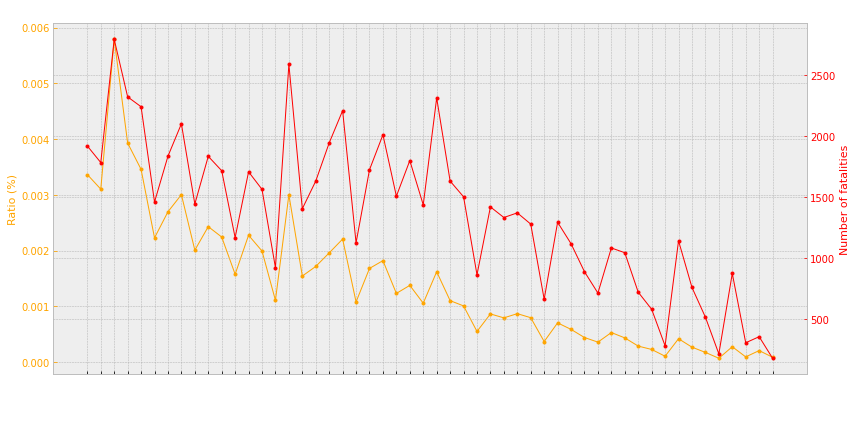

In [45]:
fig =plt.figure(figsize=(12,6))
ax1 = fig.subplots()
ax1.plot(Totals.index, 'Ratio', data=Totals, color='orange', marker = ".", linewidth=1)
ax1.set_xlabel('Year', fontsize=11, color='white')
for label in ax1.xaxis.get_ticklabels():
        label.set_rotation(45)
        label.set_color('white')
ax1.set_ylabel('Ratio (%)', color='orange', fontsize=11)
ax1.tick_params('y', colors='orange')
ax2 = ax1.twinx()
ax2.plot(Fatalities.index, 'Fatalities', data=Fatalities, color='red', marker = ".", linewidth=1)
ax2.set_ylabel('Number of fatalities', color='red', fontsize=11)
ax2.tick_params('y', colors='red')
plt.title('Fatalities VS Ratio by Year', loc='Center', color='white',fontsize=14)
fig.tight_layout()
plt.show()

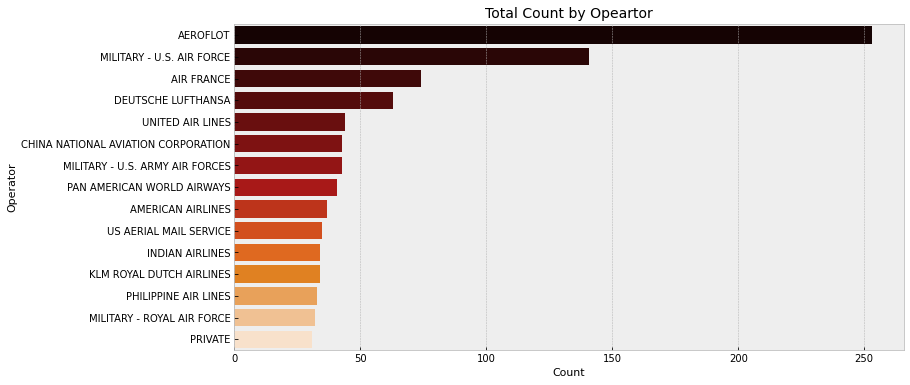

In [46]:
data.Operator = data.Operator.str.upper()
data.Operator = data.Operator.replace('A B AEROTRANSPORT', 'AB AEROTRANSPORT')

Total_by_Op = data.groupby('Operator')[['Operator']].count()
Total_by_Op = Total_by_Op.rename(columns={"Operator": "Count"})
Total_by_Op = Total_by_Op.sort_values(by='Count', ascending=False).head(15)

plt.figure(figsize=(12,6))
sns.barplot(y=Total_by_Op.index, x="Count", data=Total_by_Op, palette="gist_heat", orient='h')
plt.xlabel('Count', fontsize=11)
plt.ylabel('Operator', fontsize=11)
plt.title('Total Count by Opeartor', loc='Center', fontsize=14)
plt.show()

Notamos que hay una gran diferencia entre el primer y segundo operador con respecto a la cantidad de accidentes. Siendo la Marca rusa "AEROFLOT" la que obtuvo mayor tasa de accidentes.

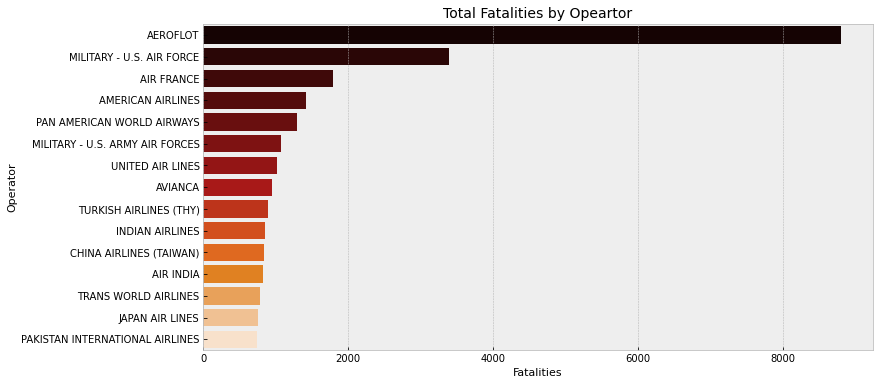

In [47]:
Prop_by_Op = data.groupby('Operator')[['Fatalities']].sum()
Prop_by_Op = Prop_by_Op.rename(columns={"Operator": "Fatalities"})
Prop_by_Op = Prop_by_Op.sort_values(by='Fatalities', ascending=False)
Prop_by_OpTOP = Prop_by_Op.head(15)

plt.figure(figsize=(12,6))
sns.barplot(y=Prop_by_OpTOP.index, x="Fatalities", data=Prop_by_OpTOP, palette="gist_heat", orient='h')
plt.xlabel('Fatalities', fontsize=11)
plt.ylabel('Operator', fontsize=11)
plt.title('Total Fatalities by Opeartor', loc='Center', fontsize=14)
plt.show()

Notamos en este gráfico tambien que para la mayor tasa de muertes vuelve a retomar el primer lugar el operador Ruso "AEROFLOT"

<AxesSubplot: title={'center': 'Count of crashes by location'}>

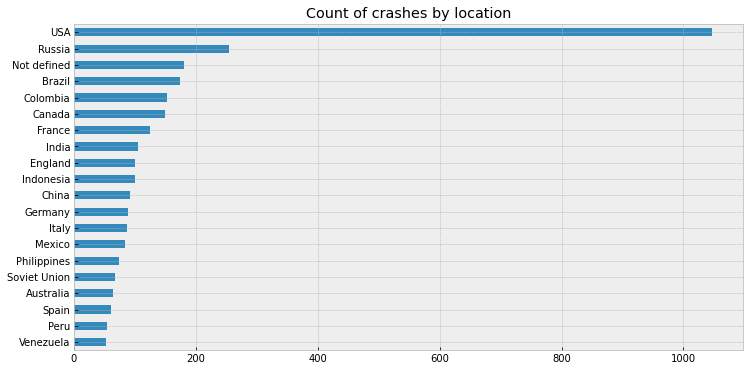

In [48]:
data['Country'].value_counts().head(20).sort_values().plot(
    kind='barh',figsize=[12, 6], title='Total accidentes por Pais (Country)')

<AxesSubplot: title={'center': 'Countries with more than 1000 total fatalities'}, xlabel='Country'>

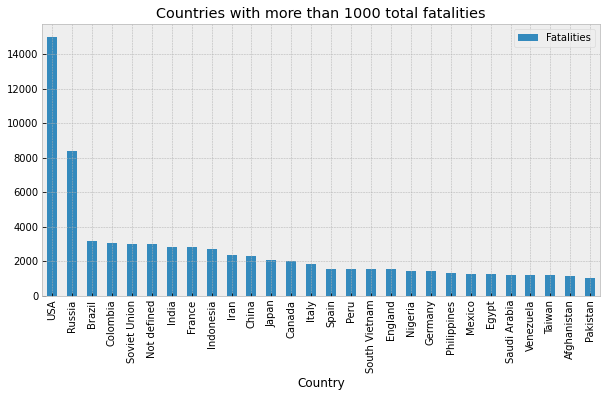

In [49]:
fatal_countries = data[['Fatalities','Country']].groupby(
    ['Country']).sum().sort_values('Fatalities', ascending=False)
fatal_countries.reset_index(inplace = True)
fatal_countries[fatal_countries['Fatalities']>1000].plot(
    x='Country', y='Fatalities', kind='bar', figsize=[10, 5], title='Paises con más de 1000 fallecidos en accidentes aereos')

### Explorando AeroFlot

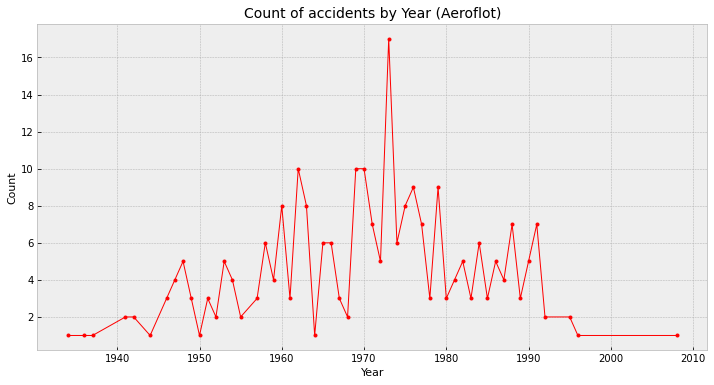

In [50]:
Aeroflot = data[data.Operator == 'AEROFLOT']

Count_by_Year = Aeroflot.groupby(data.DateTime.dt.year)[['Date']].count()
Count_by_Year = Count_by_Year.rename(columns={"Date": "Count"})

plt.figure(figsize=(12,6))
plt.plot(Count_by_Year.index, 'Count', data=Count_by_Year, marker='.', color='red', linewidth=1)
plt.xlabel('Year', fontsize=11)
plt.ylabel('Count', fontsize=11)
plt.title('Cantidad de accidentes por año (Aeroflot)', loc='Center', fontsize=14)
plt.show()

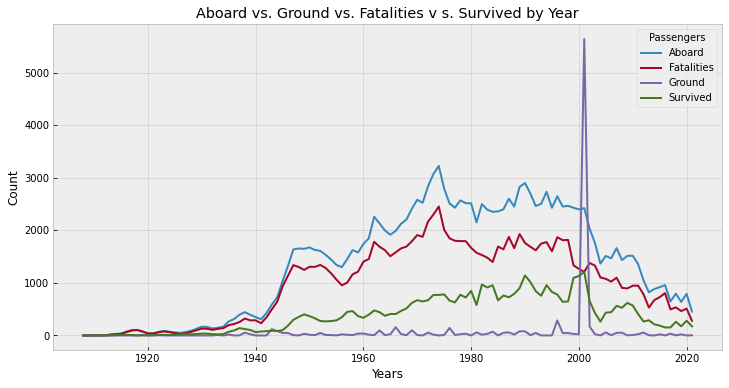

In [51]:
aboard_year = data[['Aboard','Year']].groupby(['Year']).sum()
aboard_year = aboard_year.rolling(3).mean().fillna(0)

fatalities_year = data[['Fatalities','Year']].groupby(['Year']).sum()
fatalities_year = fatalities_year.rolling(3).mean().fillna(0)

survived_year = data[['Survived','Year']].groupby(['Year']).sum()
survived_year = survived_year.rolling(3).mean().fillna(0)

ground_year = data[['Ground','Year']].groupby(['Year']).sum()


plt.figure(figsize=(12,6))

plt.plot(aboard_year, label='Aboard')
plt.plot(fatalities_year, label='Fatalities')
plt.plot(ground_year, label='Ground')
plt.plot(survived_year, label='Survived')

plt.legend(title='Passengers')

plt.ylabel('Count')
plt.xlabel('Years')
plt.title('Aboard vs. Ground vs. Fatalities v s. Survived by Year')


plt.show()

notamos en esta grafica que se crea un outlier en el año 2001 para la linea ground, la razón es por la tragedia que sucedio en "USA" con las torres gemelas, ya que el daño colateral fue demasiado grande.

In [52]:
data.to_csv('Base de datos principal.csv', index=False)
Totals.to_csv('Base de datos complementario.csv', index=False)